# <b>GOAL</b>: Visualize and Prepare features to feed into ML Models


# Table of contents | Summary
1. [ <i>Import</i> Libraries ](#libs)
2. [<i>Read in</i> Training and Testing Data via (csv) & <i>Merge</i>](#Read-In-Data)
3. [<i>Load</i> Helper Functions](#helpers)
4. [<i>Understanding the Data</i>: Missing Values, Shape, Duplicates](#understanding)
    1. [CHECK for Duplicates](#duplicates)
    2. [DROP 'jobId' as the unique identifier](#dropid)
5. [<i>Split Train df</i> into Numerical and Categorical df's](#splitdf)
    1. [UNDERSTAND Distribution of Numerical Data](#numdist)
6. [Understanding <i>Categorical</i> Features vs. Salary](#catvsalary)
    1. [One Hot Encode (cat df) to feed into ML model](#ohe)
7. [Understanding <i>Numerical</i> Features vs. Salary](#numvsalary)
8. [<i>Create </i>ID column](#id)
9. [<i>Merge </i> cat and numeric dfs <i>on</i> ID column ](#merge)
10. [Find outliers in the Target variable: LOW and HIGH](#outlierhead)
    1. [UPPER outliers](#upperout)
    2. [LOWER outliers](#lowerout)
    3. [DROP outliers from X_full dataframe](#dropout)
11. [<i>Create</i> Train and Target tables w/ train_test_split](#train)
    1. [<i>Create</i> Validation Set from Train data](#val)
12. [<i>Pickle</i> Train/ Validation/ and Test Data](#pickle)

## 1. <i>Import</i> Libraries <a name = "libs"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle

from sklearn.model_selection import train_test_split

__author__ = "Sid Vanam"
__email__ = "vanamsid@gmail.com"

## 2. <i>Read in</i> Training and Testing Data via (csv) & <i>Merge</i><a name="Read-In-Data"></a>

In [2]:
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')

train_sal = pd.read_csv("train_salaries.csv") #contains only jobID and Salary columns -> merge with Train_Features

In [3]:
#Merge Training Datasets on 'jobId'
train_full = train_features.merge(train_sal, on = 'jobId')
train_full.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


Understand that **"jobId" & "companyId"** are ***unique identifiers*** for each survey respondant and company

## 3. <i>Load</i> Helper Functions <a name = "helpers"></a>

In [4]:
def feature_order(feature, ascending = True):
    ''' Return s a list of the feature from LOW -> HIGH'''
    grouped_df = train_full.groupby(feature)['salary'].mean().sort_values().reset_index()
    if ascending == False:
        sorted_df = grouped_df.sort_values(by = 'salary', ascending = False).reset_index()
        return sorted_df[feature].tolist()
    else:
        sorted_df = grouped_df.sort_values(by = 'salary', ascending = True).reset_index()
        return sorted_df[feature].tolist()

def plot_viz(feature):
    ''' Plots Feature against Salary (Boxenplot)'''
    plt.figure(figsize = (20,7))
    plt.title(feature + ' vs. Salary')
    plt.ylabel('Salary')
    plt.xlabel(feature)
    if feature == 'companyId':
        plt.xticks(rotation = 90)
    
    return sns.boxenplot(x = feature, y = 'salary', data = train_full, order = feature_order(feature))

def find_outliers(df, feature, lower = False, view = 10):
    ''' Returns the Top 10 lowest or highest outlier employees'''
    describe_df = df[feature].describe().reset_index()
    if lower == True:
        q1 = describe_df.iloc[4][feature]
        return df.loc[df[feature] < q1].sort_values(by= feature, ascending = True).head(view)
    else:
        q3 = describe_df.iloc[6][feature]
        return df.loc[df[feature] > q3].sort_values(by= feature, ascending = False).head(view)

## 4. <i>Understanding the Data</i>: Missing Values, Shape, Duplicates<a name ="understanding"></a>

In [5]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [6]:
print("There are also NO missing values as shown in the Non-null column")

There are also NO missing values as shown in the Non-null column


In [7]:
print('There are {} Train samples and {} Test samples'.format(train_full.shape[0], test_features.shape[0]))

There are 1000000 Train samples and 1000000 Test samples


### A. CHECK for Duplicates <a name = "duplicates"></a>

In [8]:
train_full[train_full.duplicated()]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


There are no Duplicate Values

### B. DROP 'jobId' as the unique identifier <a name = "dropid"></a>

In [9]:
train_full = train_full.drop('jobId', axis = 1)
train_full.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


## 5. <i>Split Train df</i> into Numerical and Categorical df's<a name = "splitdf"></a>

In [10]:
cat = train_full.select_dtypes(include= 'object')
cat.head()

,companyId,jobType,degree,major,industry
0,COMP37,CFO,MASTERS,MATH,HEALTH
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE


In [11]:
numeric = train_full.select_dtypes(exclude= 'object')
numeric.head()

,yearsExperience,milesFromMetropolis,salary
0,10,83,130
1,3,73,101
2,10,38,137
3,8,17,142
4,8,16,163


### A. UNDERSTAND Distribution of Numerical Data<a name = "numdist"></a>

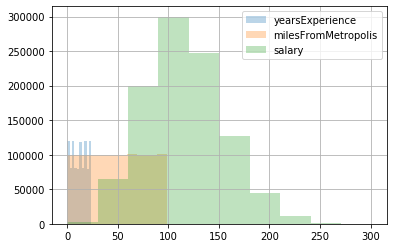

In [12]:
for col in numeric.columns.tolist():
    numeric[col].hist(alpha = 0.3)
    plt.legend([col for col in numeric.columns])

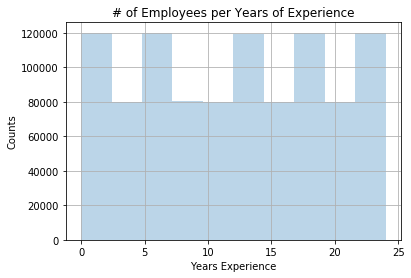

In [13]:
plt.title('# of Employees per Years of Experience')
plt.ylabel('Counts')
plt.xlabel('Years Experience')
numeric['yearsExperience'].hist(alpha = 0.3)

**Summary**: Salary follows a relatively ***Normal Gaussian Distribution***.
- yearsExperience and milesFromMetropolis are **uniformly distributed** and relatively **symmetrical**

## 6. Understanding <i>Categorical</i> Features vs. Salary <a name = "catvsalary"></a>

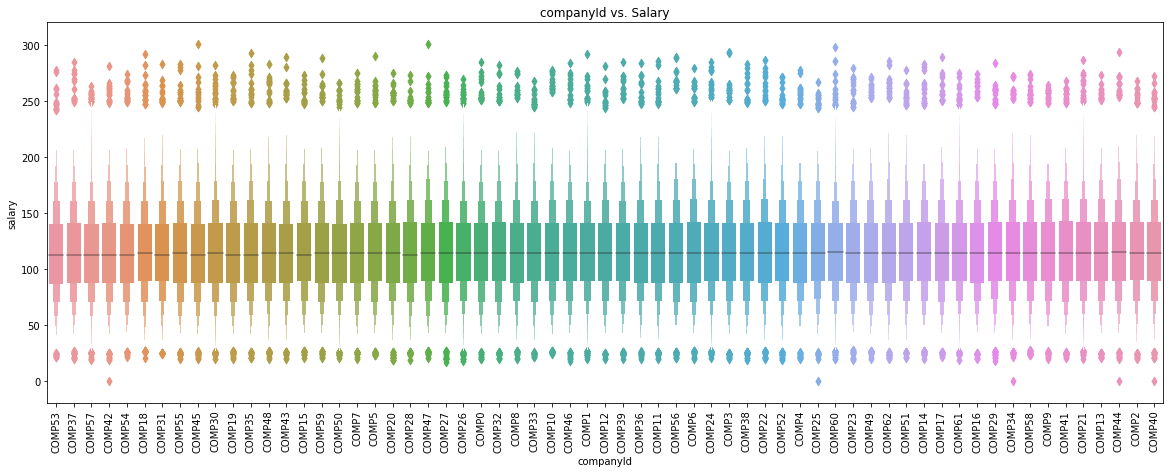

In [14]:
plot_viz('companyId')

**Summary**: Salary tends to be relatively ***constant*** across different companies.

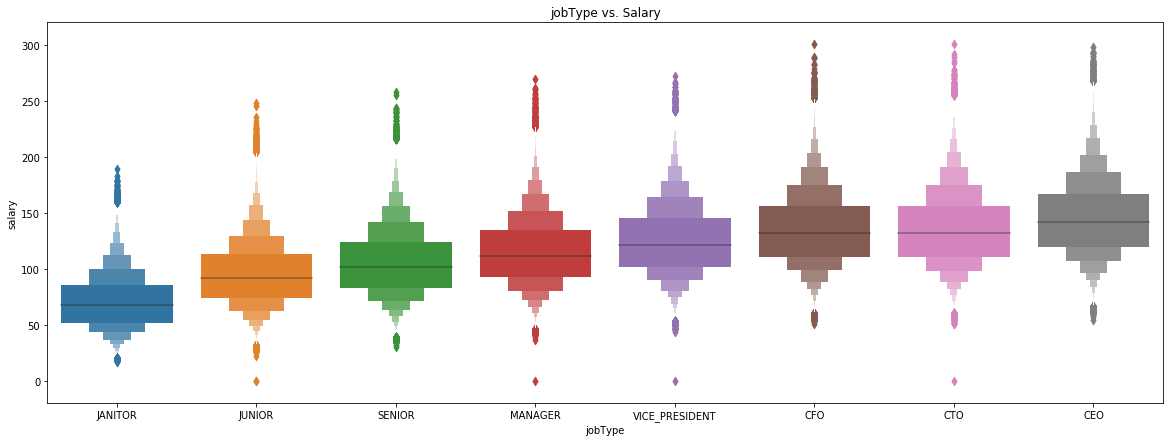

In [15]:
plot_viz('jobType')

**Summary**: Salary ***increases*** as one gets a better jobType.

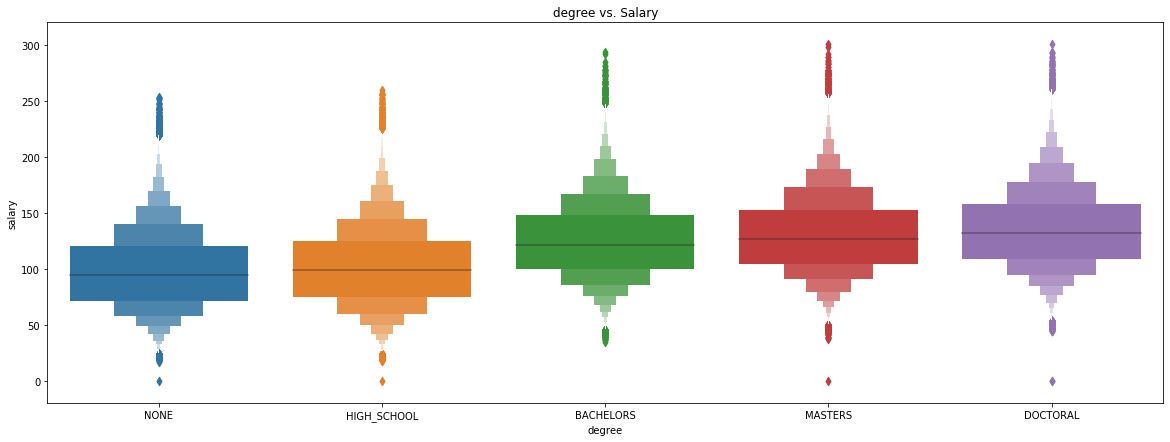

In [16]:
plot_viz('degree')

**Summary**: Salary ***increases*** the more advanced a degree one has.

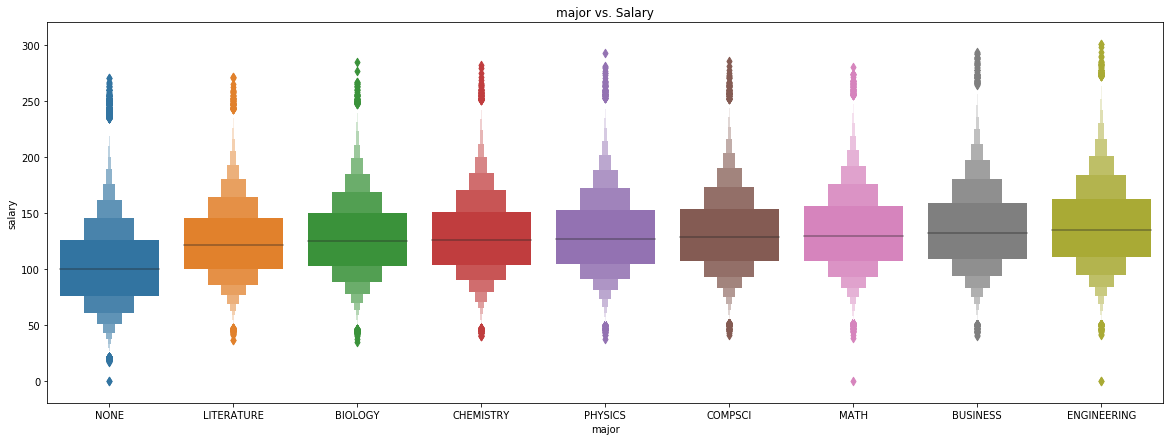

In [17]:
plot_viz('major')

**Summary**: Salary is ***higher on average*** for Math, Business, and Engineering majors.

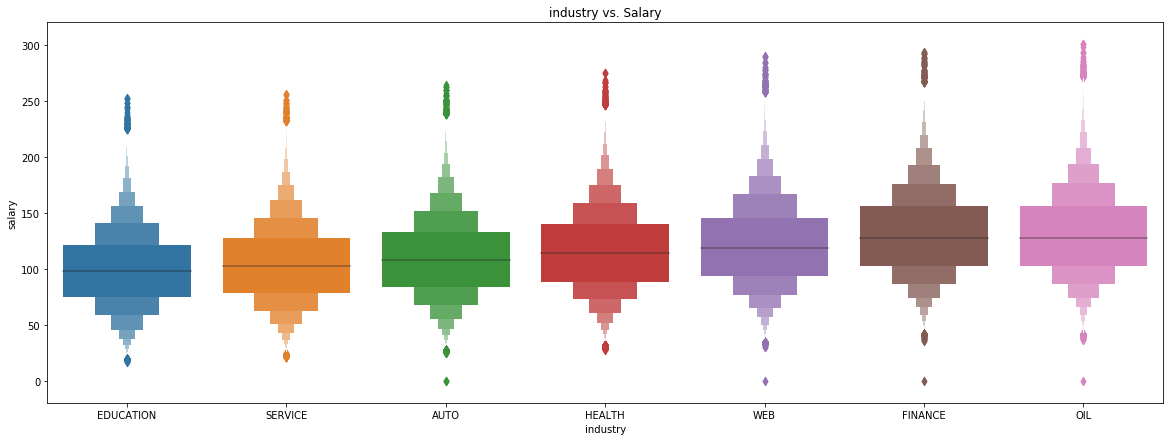

In [18]:
plot_viz('industry')

**Summary**: Salary is ***higher on average*** for employees in Web, Finance, and Oil industries.

In [19]:
cat = cat.drop('companyId', axis = 1) #Can't be introduced into a model in a meaningful way as it has similar AVG Salaries

### A. One Hot Encode (cat df) to feed into ML model <a name = "ohe"></a>

In [20]:
OH_cat = pd.get_dummies(cat, drop_first= True)

## 7. Understanding <i>Numerical</i> Features vs. Salary <a name = "numvsalary"></a>

Find the correlation of the numerical features in the Training Data

In [21]:
train_full.corr()

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000673,0.375013
milesFromMetropolis,0.000673,1.000000,-0.297666
salary,0.375013,-0.297666,1.000000


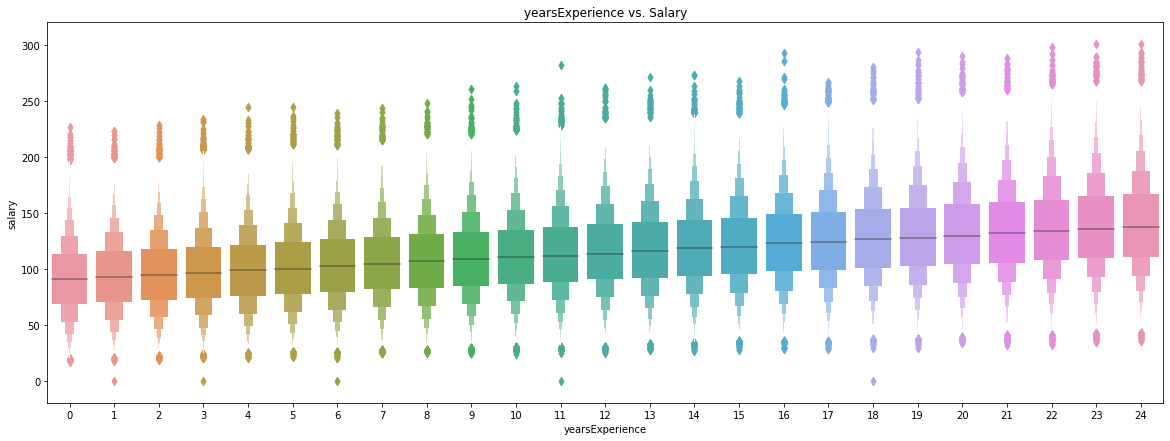

In [22]:
plot_viz('yearsExperience')

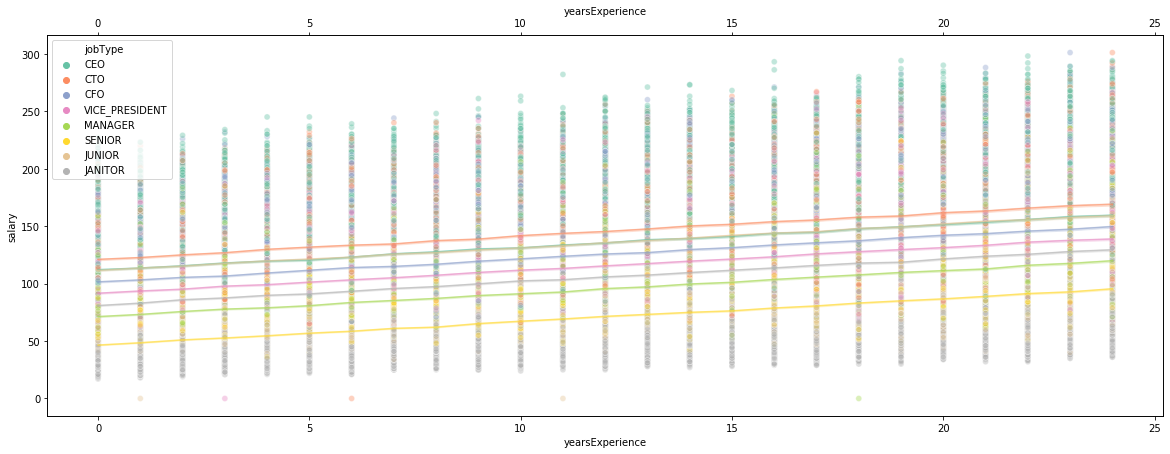

In [23]:
fig, ax0 = plt.subplots(figsize= (20,7))
ax0 = sns.scatterplot(x = 'yearsExperience', y = 'salary', data= train_full, hue = 'jobType',
                      palette= 'Set2', alpha = 0.4, hue_order= feature_order('jobType',ascending = False))
ax1 = ax0.twiny()
ax1 = sns.lineplot(x = 'yearsExperience', y = 'salary', data= train_full,
                hue = 'jobType', palette= 'Set2', alpha = 0.6, legend= False)

**Summary**: YearsExperience & jobType have a ***positive*** correlations with salary: Salary **increases** with more experience and a better title in the organization.

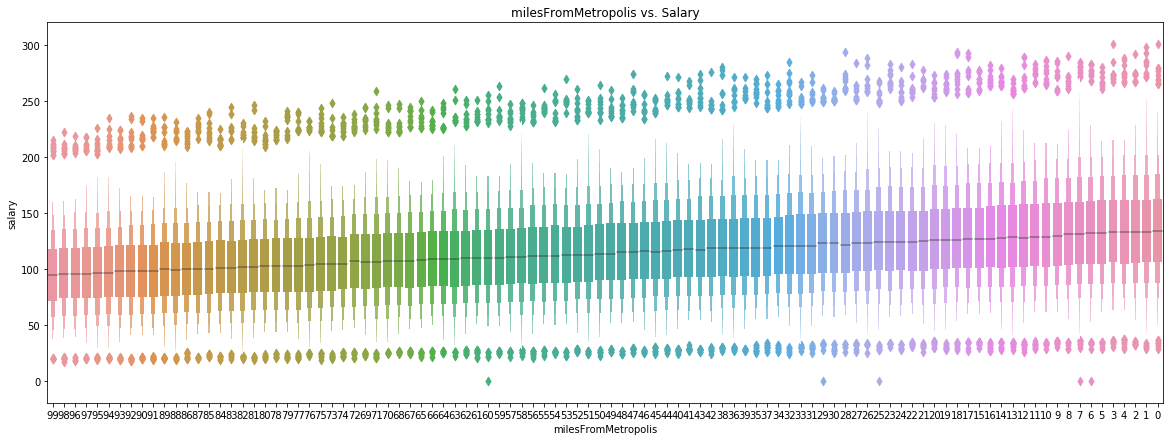

In [24]:
plot_viz('milesFromMetropolis')

**Summary**: milesFromMetropolis has a ***negative*** correlation with salary: Employees get paid less the more miles they travel to work. <t>This trend is also consistent with the *correlation table* above.

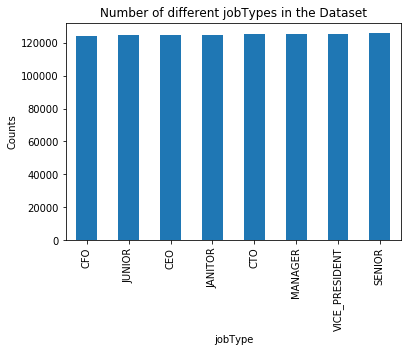

In [25]:
plt.title('Number of different jobTypes in the Dataset')
plt.ylabel('Counts')
train_full.groupby('jobType')['salary'].count().sort_values(ascending = True).plot(kind = 'bar')

**Summary**: The Distribution of jobTypes is relatively *equal*

## 8. <i>Create </i>ID column <a name = "id"></a>

In [26]:
OH_cat['id'] = range(OH_cat.shape[0])
numeric['id'] = range(numeric.shape[0])

/Users/vanamsid/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 9. <i>Merge </i> cat and numeric dfs <i>on</i> ID column <a name = "merge"></a>

In [27]:
X_full = pd.merge(OH_cat,numeric, on = 'id')

In [28]:
X_full = X_full.drop('id', axis = 1) #drop ID column after merging

## 10. Find outliers in the Target variable: LOW and HIGH<a name = "outlierhead"></a>

### UPPER outliers<a name = "upperout"></a>

In [29]:
upper_outliers = find_outliers(train_full, feature = 'salary', lower = False)
upper_outliers

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
685562,COMP47,CTO,MASTERS,ENGINEERING,OIL,24,0,301
400611,COMP45,CFO,DOCTORAL,ENGINEERING,OIL,23,3,301
572777,COMP60,CEO,MASTERS,ENGINEERING,OIL,22,1,298
911747,COMP3,CEO,BACHELORS,BUSINESS,FINANCE,24,28,294
293221,COMP44,CEO,DOCTORAL,ENGINEERING,OIL,19,18,294
905713,COMP35,CEO,DOCTORAL,BUSINESS,FINANCE,16,17,293
503962,COMP3,CEO,DOCTORAL,PHYSICS,OIL,24,1,293
884902,COMP1,CTO,MASTERS,BUSINESS,FINANCE,24,2,292
47203,COMP18,CEO,BACHELORS,BUSINESS,FINANCE,22,18,292
377196,COMP5,CEO,DOCTORAL,ENGINEERING,WEB,20,8,290


**Summary**: Nothing totally unusual about the upper-bound outliers. There are some high paying salaries for individuals with only 'Bachelors' degrees but often they are CEOs and so this inflated salary is justified.

With more time we would learn more information about these unique employees with lower education and a higher position in the company

### LOWER outliers<a name = "lowerout"></a>

In [30]:
#LOW
lower_outliers = find_outliers(train_full, 'salary', lower = True, view = 5)
lower_outliers

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
495984,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
828156,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0
816129,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
30559,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
652076,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0


**Summary**: Suspicious to find salaries = 0, higher levels positions such as "Vice Presidents" and "CTOs" should earn some money. 
Similarly we assume there are no unpaid internships for Junior jobTypes. But in reality we would check with the data source or data collection team to inquire more about these outliers.
### DROP outliers from X_full dataframet <a name = "dropout"></a>

In [31]:
outlier_indices = lower_outliers.reset_index().iloc[:5]['index'] #locate outliers

In [32]:
''' Drop outliers from Full Train and Test Data'''
X_full = X_full.drop(outlier_indices)
test_features = test_features.drop(outlier_indices)

## <i>Create</i> Train and Target tables w/ train_test_split <a name = "train"></a>

In [33]:
y_full = X_full['salary']
X_Full = X_full.drop('salary', axis = 1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_Full, y_full, shuffle = True,
            test_size = 0.2, random_state = 42)

**Result:** Allocates 20% of the data for testing while using the remaining 80% for training the models

### Create Validation Set from Train data <a name = "val"></a>
- Creates a 60k/20k/20k split for Train/Validation/Test data

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## <i>Pickle</i> Train/ Validation/ and Test Data<a name = "pickle"></a>

In [36]:
'''Pickle Training Data'''
with open('../salary prediction data/Pickle Data/TRAIN_X.pkl', 'wb') as temp0:
    pickle.dump(X_train, temp0)
with open('../salary prediction data/Pickle Data/TRAIN_Y.pkl', 'wb') as temp1:
    pickle.dump(y_train, temp1)

In [37]:
'''Pickle Validation Data'''
with open('../salary prediction data/allPickle Data/VALID_X.pkl', 'wb') as temp2:
    pickle.dump(X_valid, temp2)
with open('../salary prediction data/Pickle Data/VALID_y.pkl', 'wb') as temp3:
    pickle.dump(y_valid, temp3)

In [38]:
'''Pickle Test Data'''
with open('../salary prediction data/Pickle Data/TEST_X.pkl', 'wb') as temp4:
    pickle.dump(X_test, temp4)
with open('../salary prediction data/Pickle Data/TEST_Y.pkl', 'wb') as temp5:
    pickle.dump(y_test, temp5)

**Foreward:** Save the split data for training, validating, and testing the models in the 'Model Training' notebook